In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [2]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder\
    .appName("SparkSQL")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

# Set the partitions to 4 or 8.
spark.conf.set("spark.sql.shuffle.partitions", 8)

In [3]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
url_listings = "http://data.insideairbnb.com/united-states/ny/new-york-city/2023-09-05/data/listings.csv.gz"
spark.sparkContext.addFile(url_listings)
listings_df = spark.read.csv(SparkFiles.get("listings.csv.gz"), sep=",", header=True, quote ='"', multiLine=True, escape = '"')

# Create a lookup table for calendar.
url_calendar="http://data.insideairbnb.com/united-states/ny/new-york-city/2023-09-05/data/calendar.csv.gz"
spark.sparkContext.addFile(url_calendar)
calendar_df = spark.read.csv(SparkFiles.get("calendar.csv.gz"), sep=",", header=True, quote ='"', multiLine=True, escape = '"')

# Create a lookup table for the airport codes.
url_reviews ="http://data.insideairbnb.com/united-states/ny/new-york-city/2023-09-05/data/reviews.csv.gz"
spark.sparkContext.addFile(url_reviews)
reviews_df = spark.read.csv(SparkFiles.get("reviews.csv.gz"), sep=",", header=True, quote ='"', multiLine=True, escape = '"')


In [4]:
# Look over the listings data.
listings_df.show()

+------------------+--------------------+--------------+------------+-----------+--------------------+--------------------+---------------------+--------------------+---------+--------------------+---------+----------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+------------------+------------------+--------------------+---------------+------------+---------+--------------+--------+----+--------------------+-------+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+----------------+---------------+---------------+---------------+--------------

In [5]:
# Look over the data for calendar.
calendar_df.show()

+----------+----------+---------+-------+--------------+--------------+--------------+
|listing_id|      date|available|  price|adjusted_price|minimum_nights|maximum_nights|
+----------+----------+---------+-------+--------------+--------------+--------------+
|      2595|2023-09-05|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-06|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-07|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-08|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-09|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-10|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-11|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-12|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-13|        t|$240.00|  

In [6]:
# Look over the review data.
reviews_df.show()

+----------+--------+----------+-----------+-------------+--------------------+
|listing_id|      id|      date|reviewer_id|reviewer_name|            comments|
+----------+--------+----------+-----------+-------------+--------------------+
|      2595|   17857|2009-11-21|      50679|         Jean|Notre séjour de t...|
|      2595|   19176|2009-12-05|      53267|         Cate|   Great experience.|
|      2595|   19760|2009-12-10|      38960|        Anita|I've stayed with ...|
|      2595|   34320|2010-04-09|      71130|      Kai-Uwe|We've been stayin...|
|      2595|   46312|2010-05-25|     117113|       Alicia|We had a wonderfu...|
|      2595| 1238204|2012-05-07|    1783688|       Sergey|Hi to everyone!\r...|
|      2595| 1293632|2012-05-17|    1870771|         Loïc|Jennifer was very...|
|      2595| 2022498|2012-08-18|    2124102|      Melanie|This apartment is...|
|      2595| 4682989|2013-05-20|     496053|         Eric|Jennifer's place ...|
|      2595|13193832|2014-05-21|   13685

In [7]:
import pandas as pd

In [8]:
listings_df.count()

39453

In [9]:
calendar_df.count()

14399996

In [10]:
reviews_df.count()

1019573

In [11]:
unique_neighbourhoods = listings_df.select('neighbourhood_cleansed').distinct()
unique_neighbourhoods_count = unique_neighbourhoods.count()
print("Count of unique neighbourhoods:", unique_neighbourhoods_count)

Count of unique neighbourhoods: 223


In [12]:
accepted_neighborhoods = ["Manhattan", "Queens", "Brooklyn"]

In [13]:
filtered_listings_df = listings_df[listings_df['neighbourhood_group_cleansed'].isin(accepted_neighborhoods)]


In [14]:
filtered_listings_df.show()

+------------------+--------------------+--------------+------------+-----------+--------------------+--------------------+---------------------+--------------------+---------+--------------------+---------------+----------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+------------------+------------------+--------------------+---------------+------------+---------+--------------+--------+----+--------------------+-------+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+----------------+---------------+---------------+---------------+------

In [15]:
filtered_listings_df.count()

37609

In [16]:
listing_columns = ['id','listing_url','name','host_id','host_url','host_name','host_since','host_is_superhost','host_listings_count','host_total_listings_count','neighbourhood_cleansed','neighbourhood_group_cleansed','latitude','longitude','room_type','accommodates','bathrooms_text','bedrooms','beds','amenities','price','minimum_nights','maximum_nights','has_availability','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','first_review','last_review','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','calculated_host_listings_count','reviews_per_month']
calendars_columns = ['listing_id','date','available','price','adjusted_price']
reviews_columns = ['listing_id','id','date','reviewer_id','reviewer_name','comments']

In [17]:
column_listings_df = filtered_listings_df[listing_columns]
column_calendars_df = calendar_df[calendars_columns]
column_reviews_df = reviews_df[reviews_columns]

In [18]:
column_listings_df = column_listings_df.withColumnRenamed('id', 'listing_id')

In [19]:
column_listings_df.show()

+------------------+--------------------+--------------------+---------+--------------------+---------------+----------+-----------------+-------------------+-------------------------+----------------------+----------------------------+------------------+------------------+---------------+------------+--------------+--------+----+--------------------+-------+--------------+--------------+----------------+-----------------+---------------------+----------------------+------------+-----------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+------------------------------+-----------------+
|        listing_id|         listing_url|                name|  host_id|            host_url|      host_name|host_since|host_is_superhost|host_listings_count|host_total_listings_count|neighbourhood_cleansed|neighbourhood_group_cleansed|          latitude|         longitude|      room_type|a

In [20]:
from pyspark.sql import SparkSession


In [21]:
# Initialize Spark session
spark = SparkSession.builder.appName("example").getOrCreate()

# Assuming you have a PySpark DataFrame named 'column_listings_df'
# Drop rows with null values in the 'listing_id' column
column_listings_df = column_listings_df.dropna(subset=['first_review'])

# Show the DataFrame after dropping null values
column_listings_df.show()

+------------------+--------------------+--------------------+---------+--------------------+---------------+----------+-----------------+-------------------+-------------------------+----------------------+----------------------------+------------------+------------------+---------------+------------+--------------+--------+----+--------------------+-------+--------------+--------------+----------------+-----------------+---------------------+----------------------+------------+-----------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+------------------------------+-----------------+
|        listing_id|         listing_url|                name|  host_id|            host_url|      host_name|host_since|host_is_superhost|host_listings_count|host_total_listings_count|neighbourhood_cleansed|neighbourhood_group_cleansed|          latitude|         longitude|      room_type|a

In [22]:
column_listings_df.count()

27708

In [23]:
column_reviews_df = column_reviews_df.dropna(subset=['comments'])
column_reviews_df.show()

+----------+--------+----------+-----------+-------------+--------------------+
|listing_id|      id|      date|reviewer_id|reviewer_name|            comments|
+----------+--------+----------+-----------+-------------+--------------------+
|      2595|   17857|2009-11-21|      50679|         Jean|Notre séjour de t...|
|      2595|   19176|2009-12-05|      53267|         Cate|   Great experience.|
|      2595|   19760|2009-12-10|      38960|        Anita|I've stayed with ...|
|      2595|   34320|2010-04-09|      71130|      Kai-Uwe|We've been stayin...|
|      2595|   46312|2010-05-25|     117113|       Alicia|We had a wonderfu...|
|      2595| 1238204|2012-05-07|    1783688|       Sergey|Hi to everyone!\r...|
|      2595| 1293632|2012-05-17|    1870771|         Loïc|Jennifer was very...|
|      2595| 2022498|2012-08-18|    2124102|      Melanie|This apartment is...|
|      2595| 4682989|2013-05-20|     496053|         Eric|Jennifer's place ...|
|      2595|13193832|2014-05-21|   13685

In [24]:
column_reviews_df.count()

1019573

**RUTVA'S CODE**

In [25]:
column_reviews_df.show()

+----------+--------+----------+-----------+-------------+--------------------+
|listing_id|      id|      date|reviewer_id|reviewer_name|            comments|
+----------+--------+----------+-----------+-------------+--------------------+
|      2595|   17857|2009-11-21|      50679|         Jean|Notre séjour de t...|
|      2595|   19176|2009-12-05|      53267|         Cate|   Great experience.|
|      2595|   19760|2009-12-10|      38960|        Anita|I've stayed with ...|
|      2595|   34320|2010-04-09|      71130|      Kai-Uwe|We've been stayin...|
|      2595|   46312|2010-05-25|     117113|       Alicia|We had a wonderfu...|
|      2595| 1238204|2012-05-07|    1783688|       Sergey|Hi to everyone!\r...|
|      2595| 1293632|2012-05-17|    1870771|         Loïc|Jennifer was very...|
|      2595| 2022498|2012-08-18|    2124102|      Melanie|This apartment is...|
|      2595| 4682989|2013-05-20|     496053|         Eric|Jennifer's place ...|
|      2595|13193832|2014-05-21|   13685

In [26]:
from pyspark.sql.functions import split, explode, lower, col

# Split comments by spaces and explode to create one word per row
words_df = column_reviews_df.select(explode(split(col("comments"), " ")).alias("word"))

# Convert words to lowercase
words_df = words_df.withColumn("word", lower(col("word")))

# # If you want to collect all words into a Python list
# word_list = words_df.rdd.map(lambda row: row.word).collect()

# Show the first 150 words
words_df.show()

+-----------------+
|             word|
+-----------------+
|            notre|
|           séjour|
|               de|
|            trois|
|nuits.\r<br/>nous|
|            avons|
|        apprécier|
|    l'appartement|
|              qui|
|              est|
|             très|
|             bien|
|           situé.|
|        agréable,|
|           propre|
|               et|
|             bien|
|          soigné.|
|            c'est|
|            idéal|
+-----------------+
only showing top 20 rows



In [27]:
import nltk # natural language toolkit
from nltk.corpus import stopwords

# Ensure you have the stopwords downloaded
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
# Filter out stopwords using PySpark's RDD operations
filtered_words_rdd = words_df.rdd.filter(lambda row: row.word not in stop_words)

# # If you want to collect filtered words into a Python list
# filtered_words = filtered_words_rdd.map(lambda row: row.word).collect()
# print(filtered_words[:30])

# Filter out stopwords and empty strings using PySpark's RDD operations
filtered_words_rdd = words_df.rdd.filter(lambda row: row.word not in stop_words and row.word.strip() != '')

# Step 2: Recount
word_counts_rdd = filtered_words_rdd.map(lambda row: (row.word, 1)).reduceByKey(lambda a, b: a + b)

# Limit to 150 rows
limited_words_df = filtered_words_rdd.toDF(["word"]).limit(150)

# Collect and print
for row in limited_words_df.collect():
    print(row.word)



notre
séjour
de
trois
<br/>nous
avons
apprécier
l'appartement
qui
est
très
bien
situé.
agréable,
propre
et
bien
soigné.
c'est
idéal
pour
une
famille
de
3
ou
4
<br/>petits
soucis
en
arrivant
il
avait
personne
pour
nous
recevoir,
et
il
manquait
le
savon
pour
la
douche,
le
liquide
vaisselle,
nous
les
avons
reçu
de
surlendemain.
il
aussi
le
bruit
du
métro
de
ny,
donc
une
première
nuit
difficile
si
est
pas
habitué.
jennifer
est
correcte
le
remboursement
de
la
caution
était
très
rapide.
part
ces
petits
détails
notre
court
séjour
c'est
bien
passé.
<br/>si
j'ai
la
possibilité
de
revenir
sur
ny
pour
les
vacances,
je
reprendrai
à
"the
midtown
<br/>possession
-
ile
de
la
<br/>
great
experience.
i've
stayed
friend
midtown
castle
six
days
lovely
place
be.
big
spacious
room
pointy
roof,
really
makes
feel
like
staying
castle.
location
perfect.
steps
macy's
time
square
theatre
district.
everything
worked
perfect
keys
etc.


In [37]:
from pyspark.sql import Row

In [57]:
from pyspark.sql.functions import count, desc

In [58]:
# Count occurrences of each word
words_count_df = limited_words_df.groupBy("word").agg(count("word").alias("count")).orderBy(desc("count"))

# Collect top 25 words
top_25_words = words_count_df.limit(25).collect()

# Convert to Python list of tuples for compatibility with the Python code style
words_count = [(row.word, row.count) for row in top_25_words]


In [59]:
print(words_count)

[('de', <built-in method count of Row object at 0x7f2a3b5c1c10>), ('pour', <built-in method count of Row object at 0x7f2a398080e0>), ('le', <built-in method count of Row object at 0x7f2a31e5c950>), ('la', <built-in method count of Row object at 0x7f2a31e5c9a0>), ('est', <built-in method count of Row object at 0x7f2a31e5c7c0>), ('bien', <built-in method count of Row object at 0x7f2a31e5d1c0>), ('il', <built-in method count of Row object at 0x7f2a31e5d440>), ('notre', <built-in method count of Row object at 0x7f2a31e5d170>), ('séjour', <built-in method count of Row object at 0x7f2a31e5d0d0>), ('avons', <built-in method count of Row object at 0x7f2a31e5cf90>), ('très', <built-in method count of Row object at 0x7f2a31e5d080>), ('et', <built-in method count of Row object at 0x7f2a31e5d210>), ("c'est", <built-in method count of Row object at 0x7f2a31e5d2b0>), ('une', <built-in method count of Row object at 0x7f2a31e5cea0>), ('nous', <built-in method count of Row object at 0x7f2a31e5cfe0>), (

In [60]:
from pyspark.sql import SparkSession
from pyspark.sql import Row

In [64]:
# Take the first 200,000 word counts
first_200k_counts = word_counts_rdd.take(200000)

# Convert the list into an RDD
first_200k_rdd = word_counts_rdd.ctx.parallelize(first_200k_counts)

# Get the top 25 occurring words from the first 200,000 words
top_25_words = first_200k_rdd.sortBy(lambda x: x[1], ascending=False).take(25)

# Convert the top 25 words list into an RDD
top_25_rdd = word_counts_rdd.ctx.parallelize(top_25_words)

# Convert the RDD into a DataFrame
top_25_df = top_25_rdd.map(lambda x: Row(word=x[0], count=x[1])).toDF()

# Show the DataFrame
top_25_df.show()



+----------+------+
|      word| count|
+----------+------+
|     great|479744|
|     place|391824|
|      stay|320319|
| apartment|218541|
|     would|202483|
|     clean|170940|
|  location|169847|
|      nice|169337|
|everything|132696|
|definitely|132198|
|    really|130302|
|      good|127022|
|     close|126515|
|      room|126199|
| recommend|124735|
|        de|123257|
|      host|121258|
|      easy|114818|
|        us|114567|
|     super|108303|
+----------+------+
only showing top 20 rows



In [65]:
#Rename the Columns
top_25_df_renamed = top_25_df.withColumnRenamed("word", "Words").withColumnRenamed("count", "Count")

# To see the changes
top_25_df_renamed.show()


+----------+------+
|     Words| Count|
+----------+------+
|     great|479744|
|     place|391824|
|      stay|320319|
| apartment|218541|
|     would|202483|
|     clean|170940|
|  location|169847|
|      nice|169337|
|everything|132696|
|definitely|132198|
|    really|130302|
|      good|127022|
|     close|126515|
|      room|126199|
| recommend|124735|
|        de|123257|
|      host|121258|
|      easy|114818|
|        us|114567|
|     super|108303|
+----------+------+
only showing top 20 rows



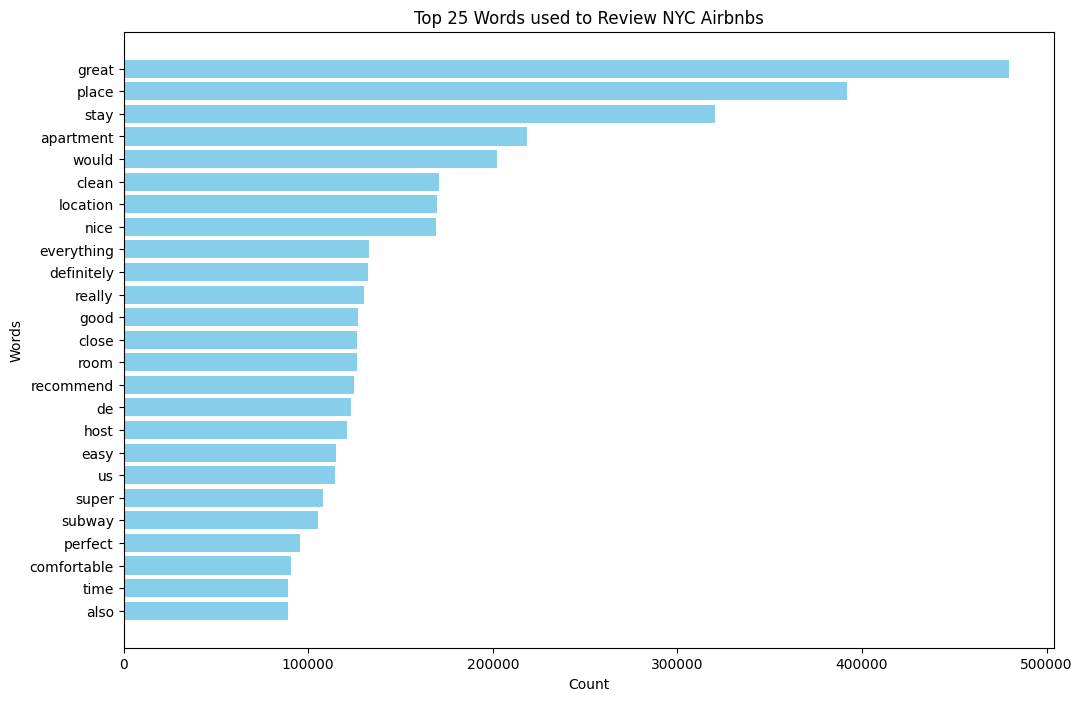

In [75]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
pdf = top_25_df_renamed.toPandas()

# Plotting
plt.figure(figsize=(12,8))
plt.barh(pdf['Words'], pdf['Count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Top 25 Words used to Review NYC Airbnbs')
plt.gca().invert_yaxis()  # This is to have the word with the highest count at the top
plt.show()


In [ ]:
# Don't forget to stop the Spark session when you're done
spark.stop()

# New Section